To run this notebook, change runtime to gpu and select run all.

In [1]:
!pip install tensorflow
!pip install datasets
!pip install torch
!pip install nltk
!pip install transformers
!pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
You should consider upgrading via the '/opt/conda/bin/python3.8 -m pip install --upgrade pip' command.
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


You should consider upgrading via the '/opt/conda/bin/python3.8 -m pip install --upgrade pip' command.
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
You should consider upgrading via the '/opt/conda/bin/python3.8 -m pip install --upgrade pip' command.
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
You should consider upgrading via the '/opt/conda/bin/python3.8 -m pip install --upgrade pip' command.
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
You should consider upgrading via the '/opt/conda/bin/python3.8 -m pip install --upgrade pip' command.
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
You should consider upgrading via the '/opt/conda/bin/python3.8 -m pip install --upgrade pip' command.


In [2]:
import torch
import numpy as np
import pandas as pd
import datasets
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from datasets import load_dataset
from transformers import BertForSequenceClassification, TFAutoModel
from transformers import DistilBertTokenizerFast
from transformers import AutoTokenizer, BertTokenizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix

%matplotlib inline

In [3]:
# get the total number of words in each sentence
df_count = pd.read_csv('data.csv')
df_count['totalwords'] = [len(x.split()) for x in df_count['question'].tolist()]

# to be prepared for tokenize max length. +2 because need to consider the [101] and [102] during tokenize
max_seq_length = df_count['totalwords'].max()+2

In [4]:
# read csv to get the data
df = pd.read_csv('data.csv')
#an example of how the label and qns look like in dataset
df

,label,question
0,payment_freq,how often do I need to pay
1,payment_freq,how often I paay
2,payment_freq,I use monthly or yearly to pay
3,payment_freq,how often do I use to pay
4,payment_freq,how often I need pay for my plan
...,...,...
3658,ad_disappear,claimable if person disappear from aircraft crash
3659,ad_disappear,claimable if person disappear from aircraf wreck
3660,ad_disappear,aircraft wreck person disappear can claim
3661,ad_disappear,got aerople crash then person disappear


## Exploratory Analysis

In [5]:
df.isnull().sum()

label       0
question    0
dtype: int64

The dataset does not have any missing value or data.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3663 entries, 0 to 3662
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   label     3663 non-null   object
 1   question  3663 non-null   object
dtypes: object(2)
memory usage: 57.4+ KB


In [7]:
df.describe()
#the row 'top' gives the highest counted value of the categorical values.
#https://stackoverflow.com/questions/54885821/what-are-is-the-use-of-top-function-in-describeinclude-all-in-python

,label,question
count,3663,3663
unique,21,3663
top,a_mobilityaid,bee sting me
freq,181,1


none of the data is duplicated which is good for the training as there would be more variation in the questions. the row 'a_mobilityaid' is the most common value's frequency. For example, it shows in the row 'top', the most frequent label appeared how many times.

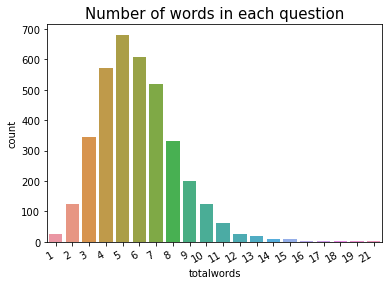

In [8]:
# let's check the number of words in questions
chart = sns.countplot(df_count['totalwords'])
# setting title of the chart
plt.title("Number of words in each question", fontsize = 15)
# setting labels to the bottom at an angle of 30 degrees
chart.set_xticklabels(chart.get_xticklabels(), rotation=30, horizontalalignment='right'); 

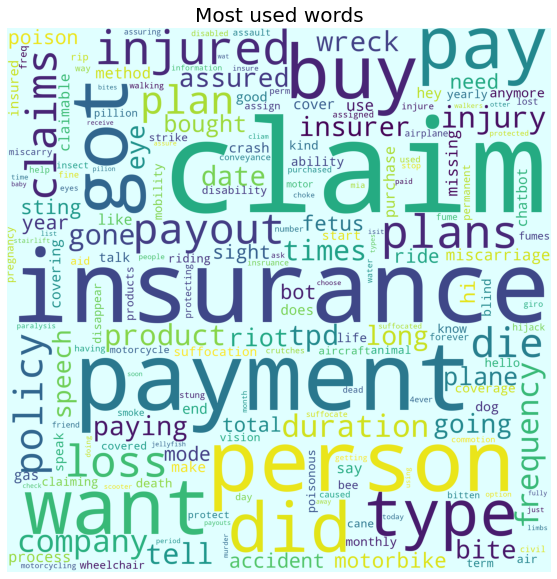

In [9]:
#Stop words are words like “and”, “the”, “him”, which are presumed to be uninformative in representing the content of a text, and which may be removed to avoid them being construed as signal for prediction.
cv = CountVectorizer(stop_words = 'english') 
words = cv.fit_transform(df['question'])
sum_words = words.sum(axis=0)

words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)

# word cloud changes everytime the code is run
wordcloud = WordCloud(background_color = 'lightcyan', width = 2000, height = 2000).generate_from_frequencies(dict(words_freq))

plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(wordcloud)
plt.title("Most used words", fontsize = 20)
plt.show()

As the topic is about insurance, the bigger words are those terms used when asking about insurance questions.

In [10]:
# find the unique labels
unique_labels = df.label.unique()
unique_labels

array(['payment_freq', 'payment_mode', 'insurer', 'product_name',
       'payout_freq', 'coverage_term', 'policy_type', 'life_assured',
       'payment_duration', 'fallback', 'welcome', 'pd_physical',
       'pd_sight', 'pd_speech', 'c_motorcycling', 'a_miscarriage',
       'a_riot', 'a_animal', 'a_mobilityaid', 'a_suffocation',
       'ad_disappear'], dtype=object)

In [11]:
# find out how many unique labels there are
len(df.label.unique())

21

<ipython-input-12-11348e1e892e>:9: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')


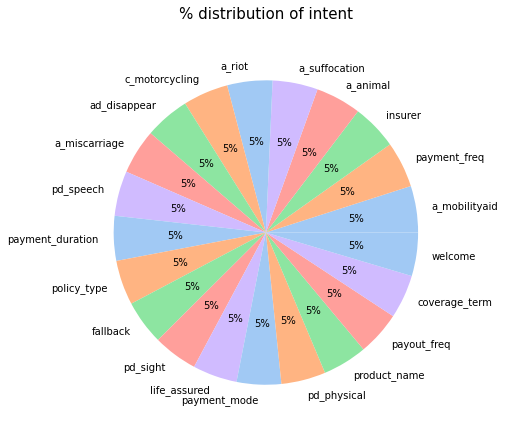

In [12]:
#define data
data = pd.DataFrame(df['label'].value_counts())
labels = pd.DataFrame(df['label'].value_counts()).index
countplt, ax = plt.subplots(figsize = (7,7))
#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:5]

#create pie chart to see the % distribution
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.title("% distribution of intent\n", fontsize = 15)
plt.show()

The dataset's intent is well distributed and no particular intent has way too many questions than the others. This is important because during the training of model, the model might be biased towards the intent with more questions and the training would not be accurate. The predictions may also be wrongly predicted as the intent with most questions.

For example, if the intent 'insurer' has 500 questions while the rest of the intent only has 100 questions, most of the prediction may be 'insurer' as questions' variation only differ slightly such as 'what is my insurance company' and 'what is my payment mode'. The model would thus learn more question variations related to the intent 'insurer' instead of the other intents. This would then make the model bias towards the intent 'insurer'.

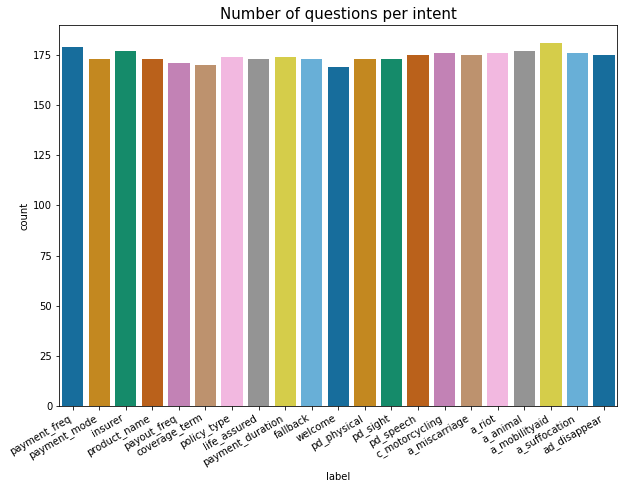

In [13]:
# let's check how the datset looks , if it is imbalanced or not
# making a chart to see how many texts are for each of the intents
countplt, ax = plt.subplots(figsize = (10,7))
chart = sns.countplot(df['label'],palette='colorblind')
# setting title of the chart
plt.title("Number of questions per intent", fontsize = 15)
# setting labels to the bottom at an angle of 30 degrees
chart.set_xticklabels(chart.get_xticklabels(), rotation=30, horizontalalignment='right'); 

## Split data

In [14]:
#split dataset into train and test, random state set ensures that the splits generated are reproducible
#0.2 test size used to split, 20% test set, 80% train set
train_txt, test_txt, train_label, test_label = train_test_split(df['question'], df['label'], test_size=0.2, random_state=42)

Data is split into train and test so that the model can train on data and test it for prediction. As this is intent classification, data would have to be split as intent and question before splitting as train and test. Thus, there would be 4 split data.

In [15]:
#see how many records are in each set
print('shape of train text:',train_txt.shape)
print('shape of train label:',train_label.shape)
print('shape of test text:',test_txt.shape)
print('shape of test label:',test_label.shape)

shape of train text: (2930,)
shape of train label: (2930,)
shape of test text: (733,)
shape of test label: (733,)


In [16]:
# an example of how the questions look like after splitting
train_txt

3449      I want to claim for poisonous fumes suffocation
31                                do I have to pay yearly
2819                                 die because got riot
2647                          got the claim for miscarry?
2666                          if I misscarry how to claim
                              ...                        
1130             what type of insurance plans were bought
1294    which person I assigned for my insurance to cover
860             the number of times insurance will pay me
3507          missing person insured after aircraft wreck
3174                            need to buy walking stick
Name: question, Length: 2930, dtype: object

In [17]:
# an example of how to label intent look like after splitting
train_label

3449    a_suffocation
31       payment_freq
2819           a_riot
2647    a_miscarriage
2666    a_miscarriage
            ...      
1130      policy_type
1294     life_assured
860       payout_freq
3507     ad_disappear
3174    a_mobilityaid
Name: label, Length: 2930, dtype: object

In [18]:
test_txt.dtype

dtype('O')

## Tokenize

In [19]:
type(train_label)

pandas.core.series.Series

As the split data is currently type pandas.core.series.Series, we have to change it to a list to prepare for data to be tokenized. test question would be prepared at a later stage using a funciton so that it can be used when customer input their question to be predicted.

In [20]:
trainq_list = train_txt.tolist()
trainl_list = train_label.tolist()
testl_list = test_label.tolist()
testq_list = test_txt.tolist()
# show first 10 questions in the list
trainq_list[:10]

['I want to claim for poisonous fumes suffocation',
 'do I have to pay yearly',
 'die because got riot',
 'got the claim for miscarry?',
 'if I misscarry how to claim',
 'list the names of the insurance',
 'the policy type of my insurance',
 'what is the plan that Is protecting me right now',
 'suffocation from downing in water',
 'payment mode for thr insurance is what']

In [21]:
# show first 10 label in the list
trainl_list[:10]

['a_suffocation',
 'payment_freq',
 'a_riot',
 'a_miscarriage',
 'a_miscarriage',
 'product_name',
 'policy_type',
 'product_name',
 'a_suffocation',
 'payment_mode']

As machine cannot understand words, we have to tokenize it by breaking the words down in a way that the machine can understand. Tokenization is the process of dividing text into a set of meaningful pieces for the machine to learn

In [22]:
# bert-base-uncased was used because it does not make a difference between lower case and upper case eg english and English
pretrained = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(pretrained)
labelencoder = LabelEncoder() #for encoding the label intent not question

tokenizer.tokenize("What is my payment Frequency?")

['what', 'is', 'my', 'payment', 'frequency', '?']

Because we are considering the uncased model, the sentence was lowercased first. 

In [23]:
#eg of how tokenize works
tokenized_input = tokenizer.encode("What is my payment Frequency?")
# will print 101, tokenized words, 102
print( tokenized_input ) 

[101, 2054, 2003, 2026, 7909, 6075, 1029, 102]


#### This markdown will show the steps of how tokenize works
Original Sentence : what is my payment frequency

Tokenized Sentence : ['what', 'is', 'my', 'payment', 'frequency']

Adding [CLS] and [SEP] Tokens : ['[CLS]', 'what', 'is', 'my', 'payment', 'frequency', '[SEP]']

Converting to IDs : [101, 2054, 2003, 2026, 7909, 6075, 102,]

#### Explanation of CLS and SEP
“CLS” is the reserved token to represent the start of sequence while “SEP” separate segment (or sentence). The whole input to the BERT has to be given a single sequence. BERT uses special tokens [CLS] and [SEP] to understand input properly. [SEP] token has to be inserted at the end of a single input.

In [24]:
# tokenize the split data's question
train_t = tokenizer(trainq_list, truncation=True, padding=True)
# an example of how the tokenized questions look like
train_t

{'input_ids': [[101, 1045, 2215, 2000, 4366, 2005, 22641, 11865, 7834, 10514, 4246, 23909, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 2079, 1045, 2031, 2000, 3477, 12142, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 3280, 2138, 2288, 11421, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 2288, 1996, 4366, 2005, 28616, 10010, 2854, 1029, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 2065, 1045, 3335, 10010, 2854, 2129, 2000, 4366, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 2862, 1996, 3415, 1997, 1996, 5427, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1996, 3343, 2828, 1997, 2026, 5427, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 2054, 2003, 1996, 2933, 2008, 2003, 8650, 2033, 2157, 2085, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 10514, 4246, 23909, 2013, 22501, 1999, 2300, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 7909, 5549, 2

In [25]:
#label encode the labels into a numeric form so as to convert them into the machine-readable form
train_l = labelencoder.fit_transform(trainl_list)
test_l = labelencoder.fit_transform(testl_list)
train_l

array([ 4, 12,  3, ..., 14,  5,  2])

In [26]:
# showing the test labels after encoding
test_l

array([11, 12, 13,  4,  0, 19, 16, 19,  2,  5, 12, 17,  0,  6,  5,  5, 14,
        8, 18,  6, 13, 18,  1, 20, 10, 14,  3,  5,  9, 13,  9,  9,  7, 11,
        1, 19, 12, 13, 18,  6, 14,  6,  2,  5, 20, 13,  9, 14,  0,  5, 12,
        9, 20, 10,  7, 15,  8, 12, 20,  0, 18,  9, 18,  3, 12,  4, 13, 20,
        3,  5,  4, 16, 11,  8, 14,  4, 15,  4, 19, 10, 15, 20, 16, 10,  2,
        8,  2, 12, 12,  7, 16, 13, 16, 17,  8, 17, 12, 14,  3, 19, 16, 12,
        5, 14, 17,  9,  8, 14, 10, 17, 14,  7, 15,  3,  9, 20, 13, 18, 19,
        7, 10,  0, 14, 13,  7,  1, 11,  0, 18, 20, 12,  2, 13,  3,  0, 17,
        8,  5,  8, 11, 18,  9, 20, 17,  8, 18, 16,  8,  0, 12, 13, 14, 16,
       10,  1, 18,  7, 20, 19, 17,  1, 16, 13,  0,  7, 13, 16,  9,  3,  8,
       13, 10,  4, 11,  4, 19, 10, 13, 20, 13,  2,  0,  1,  2,  9,  6, 14,
        7,  9, 12,  1,  7, 13, 20, 19,  2,  3,  0,  1, 17,  8,  7,  0,  5,
        6, 11, 16,  4, 12,  4,  6,  1, 16, 11,  4, 14,  7,  0, 20,  2, 13,
       15, 18,  2,  6, 18

## Preparing

In [27]:
# turn our labels and encodings into a Dataset object
# an example of how this class was used https://huggingface.co/transformers/v3.4.0/custom_datasets.html

class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])


In [28]:
# function for preparing the test dataset for prediction as well as customer's input qns. 
#train dataset don't need to have function as it would not have a new dataset such as the customer input in the chatbot
def preparing(testq, tokenizer):
    testq_list = testq.tolist()
    test_t = tokenizer(testq_list, truncation=True, padding=True)
    return test_t

In [29]:
train_dataset = Dataset(train_t, train_l.tolist())
train_dataset

In [30]:
test_dataset = Dataset(preparing(test_txt,tokenizer), test_l.tolist())
test_dataset

In [31]:
# showing the unique labels after encoding
uniquel = np.unique(train_l)
uniquel

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20])

In [32]:
model = BertForSequenceClassification.from_pretrained(pretrained, num_labels=len(uniquel))
model

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [33]:
from transformers import TrainingArguments
# https://github.com/huggingface/transformers/issues/8910
# set logging_steps as a lower number than no of epochs running else the logging for train loss won't come out
training_args = TrainingArguments("test_trainer", num_train_epochs=5, 
                                  evaluation_strategy="epoch", logging_steps=2)
training_args

TrainingArguments(
_n_gpu=8,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
bf16=False,
bf16_full_eval=False,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_steps=None,
evaluation_strategy=IntervalStrategy.EPOCH,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
gradient_accumulation_steps=1,
gradient_checkpointing=False,
greater_is_better=None,
group_by_length=False,
half_precision_backend=auto,
hub_model_id=None,
hub_strategy=HubStrategy.EVERY_SAVE,
hub_token=<HUB_TOKEN>,
ignore_data_skip=False,
label_names=None,
label_smoothing_factor=0.0,
learning_rate=5e-05,
length_column_name=length,
load_best_model_at_end=False,
local_rank=-1,
log_level=-1,
log_level_replica=-1,
log_on_each_node=True,
logging_dir=test_trainer/runs/Fe

In [34]:
# huggingface's metric was used to check the model's accuracy and other scores during training
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

def compute_metrics(pred):
    logits, labels = pred
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='micro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

## Train

In [35]:
from transformers import Trainer
import numpy as np

trainer = Trainer(
    model=model, 
    args=training_args,
    train_dataset=train_dataset, 
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)


In [36]:
# training of the data would take place here, the logging would show the progress of training in the form of a table per epoch
trainer.train()

/opt/conda/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2930
  Num Epochs = 5
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 230
/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.606600,1.451327,0.836289,0.836289,0.836289,0.836289
2,0.542300,0.460349,0.945430,0.945430,0.945430,0.945430
3,0.231600,0.197984,0.971351,0.971351,0.971351,0.971351
4,0.095200,0.129565,0.982265,0.982265,0.982265,0.982265
5,0.106800,0.117782,0.980900,0.980900,0.980900,0.980900


***** Running Evaluation *****
  Num examples = 733
  Batch size = 64
***** Running Evaluation *****
  Num examples = 733
  Batch size = 64
***** Running Evaluation *****
  Num examples = 733
  Batch size = 64
***** Running Evaluation *****
  Num examples = 733
  Batch size = 64
***** Running Evaluation *****
  Num examples = 733
  Batch size = 64


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=230, training_loss=0.773887916168441, metrics={'train_runtime': 65.6663, 'train_samples_per_second': 223.098, 'train_steps_per_second': 3.503, 'total_flos': 195773628281400.0, 'train_loss': 0.773887916168441, 'epoch': 5.0})

In [37]:
bbu_10 = trainer.evaluate() # this is the actual metrics after prediction
bbu_10

***** Running Evaluation *****
  Num examples = 733
  Batch size = 64


{'eval_loss': 0.11778206378221512,
 'eval_accuracy': 0.9809004092769441,
 'eval_f1': 0.9809004092769441,
 'eval_precision': 0.9809004092769441,
 'eval_recall': 0.9809004092769441,
 'eval_runtime': 1.1837,
 'eval_samples_per_second': 619.259,
 'eval_steps_per_second': 10.138,
 'epoch': 5.0}

In [38]:
# get logging history of the metrics
#https://discuss.huggingface.co/t/logs-of-training-and-validation-loss/1974/5
loghist = trainer.state.log_history

def getkey(dict):
    return list(dict.keys())

for i in loghist:
    print(getkey(i))

['loss', 'learning_rate', 'epoch', 'step']
['loss', 'learning_rate', 'epoch', 'step']
['loss', 'learning_rate', 'epoch', 'step']
['loss', 'learning_rate', 'epoch', 'step']
['loss', 'learning_rate', 'epoch', 'step']
['loss', 'learning_rate', 'epoch', 'step']
['loss', 'learning_rate', 'epoch', 'step']
['loss', 'learning_rate', 'epoch', 'step']
['loss', 'learning_rate', 'epoch', 'step']
['loss', 'learning_rate', 'epoch', 'step']
['loss', 'learning_rate', 'epoch', 'step']
['loss', 'learning_rate', 'epoch', 'step']
['loss', 'learning_rate', 'epoch', 'step']
['loss', 'learning_rate', 'epoch', 'step']
['loss', 'learning_rate', 'epoch', 'step']
['loss', 'learning_rate', 'epoch', 'step']
['loss', 'learning_rate', 'epoch', 'step']
['loss', 'learning_rate', 'epoch', 'step']
['loss', 'learning_rate', 'epoch', 'step']
['loss', 'learning_rate', 'epoch', 'step']
['loss', 'learning_rate', 'epoch', 'step']
['loss', 'learning_rate', 'epoch', 'step']
['loss', 'learning_rate', 'epoch', 'step']
['eval_loss

In [39]:
loss = []
eval_loss = []
eval_accuracy = []
epoch_4 = []
epoch_10 = []
eval_loss5 = ''
eval_accuracy5 = ''

for i in loghist[:-2]: #used get the different values in dictionary and append them accordingly
    if len(getkey(i)) == 4:
        if getkey(i)[0]=='loss':
            loss.append(i.get('loss'))
        if getkey(i)[2]=='epoch':
            epoch_4.append(i.get('epoch'))
    elif len(getkey(i)) == 10:
        if getkey(i)[0]=='eval_loss':
            eval_loss.append(i.get('eval_loss'))
        if getkey(i)[1]=='eval_accuracy':
            eval_accuracy.append(i.get('eval_accuracy'))
        if getkey(i)[-2]=='epoch':
            epoch_10.append(i.get('epoch'))
            if i.get('epoch') == 2:
                eval_loss5 = i.get('eval_loss')
                eval_accuracy5 = i.get('eval_accuracy')
    
history_4 = np.array([epoch_4, loss])
history_10 = np.array([epoch_10, eval_loss, eval_accuracy])

In [40]:
# function to make graph
def plot_loss(history_10, history_4):
# Use a log scale to show the wide range of values.
    plt.plot(history_10[0],  history_10[1],
               color='red', label='Validation Loss')
    plt.plot(history_4[0],  history_4[1],
          color='green', label='Training Loss',
          linestyle="--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    plt.legend()

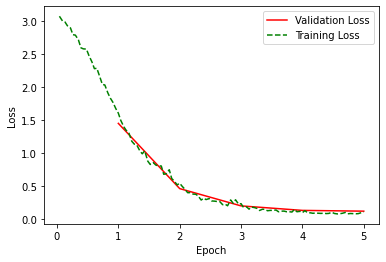

In [41]:
#see the training loss vs validation loss
plot_loss(history_10, history_4)

In [42]:
# function to make graph
def loss_accuracy(history):
# Use a log scale to show the wide range of values.
    plt.plot(history_10[0],  history_10[1],
               color='red', label='Validation Loss')
    plt.plot(history_10[0],  history_10[2],
          color='green', label='Accuracy',
          linestyle="--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss/Accuracy')
    
    plt.legend()

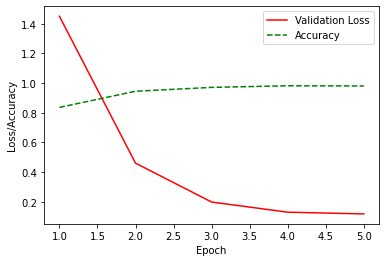

In [43]:
#see the loss and accuracy of the training
loss_accuracy(history_10)

## Predict

In [44]:
# getting the results from the prediction output
results = trainer.predict(test_dataset).predictions.argmax(1)
results

***** Running Prediction *****
  Num examples = 733
  Batch size = 64
/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


array([11, 12, 13,  4,  0, 19, 16, 19,  2,  5, 12, 17,  0,  6,  5,  5, 14,
        8, 18,  6, 13, 18,  1, 20, 10, 12,  3,  5, 10, 13,  9,  9,  7, 11,
        1, 19, 12, 13, 18,  6, 14,  6,  2,  5, 20, 13,  9, 14,  0,  5, 12,
        9, 20, 10,  7, 15,  8, 12, 20,  0, 18,  9, 18,  3, 12,  4, 13, 20,
        3,  5,  4, 16, 11,  8, 14,  4, 15,  4, 19, 10, 15, 20, 16, 10,  2,
        8,  2, 12, 12,  7, 16, 13, 16, 17,  8, 17, 12, 12,  3, 19, 16, 12,
        5, 14, 17,  9,  8, 14, 10, 17, 14,  7, 15,  3,  9, 20, 13, 18, 19,
        7, 10,  0, 14, 13,  7,  1, 11,  0, 18, 20, 12,  2, 13,  3,  0, 17,
        8,  5,  8, 11, 18,  9, 20, 17,  3, 18, 16, 10,  0, 12, 13, 14, 16,
       10,  1, 18,  7, 20, 19, 17,  1, 16, 13,  0,  7, 13, 16,  9,  3,  8,
       13, 10,  4, 11,  4, 19, 10, 13, 20, 13,  2,  0,  1,  2,  9,  6, 14,
        7,  9, 12,  1,  7, 13, 20, 19,  2,  3,  0,  1, 17,  8,  7,  0,  5,
        6, 11, 15,  4, 12,  4,  6,  1, 16, 11,  4, 14,  7,  0, 20,  2, 13,
       15, 18,  2,  6, 18

In [45]:
# as the results above are represented in tokenized form for machine readability, we would be convering to words here
y_pred = labelencoder.inverse_transform(results)
y_pred

array(['payment_duration', 'payment_freq', 'payment_mode',
       'a_suffocation', 'a_animal', 'product_name', 'pd_sight',
       'product_name', 'a_mobilityaid', 'ad_disappear', 'payment_freq',
       'pd_speech', 'a_animal', 'c_motorcycling', 'ad_disappear',
       'ad_disappear', 'payout_freq', 'fallback', 'policy_type',
       'c_motorcycling', 'payment_mode', 'policy_type', 'a_miscarriage',
       'welcome', 'life_assured', 'payment_freq', 'a_riot',
       'ad_disappear', 'life_assured', 'payment_mode', 'insurer',
       'insurer', 'coverage_term', 'payment_duration', 'a_miscarriage',
       'product_name', 'payment_freq', 'payment_mode', 'policy_type',
       'c_motorcycling', 'payout_freq', 'c_motorcycling', 'a_mobilityaid',
       'ad_disappear', 'welcome', 'payment_mode', 'insurer',
       'payout_freq', 'a_animal', 'ad_disappear', 'payment_freq',
       'insurer', 'welcome', 'life_assured', 'coverage_term',
       'pd_physical', 'fallback', 'payment_freq', 'welcome', 'a_anima

In [46]:
# preparing the dataset by using dataframe so as to join them together as tables in the code below
test_labels = pd.DataFrame(test_label)
test_txts = pd.DataFrame(test_txt)

In [47]:
# join the tables from the above code with the results to compare the predictions with the actual labels
# predictions column is the prediction of the model while label column is the actual label in the dataset
test_labels['predictions'] = y_pred
test = test_txts.join(test_labels, how="outer")
test

,question,label,predictions
1474,when is the payment going to end,payment_duration,payment_duration
93,what kind of frequency do I have to pay,payment_freq,payment_freq
315,what is the technique that I used for payment ...,payment_mode,payment_mode
3437,how to claim for injured lungs by suffocation ...,a_suffocation,a_suffocation
3096,animal sting can cliaim or not,a_animal,a_animal
...,...,...,...
67,what is the required number of times I have to...,payment_freq,payment_freq
1832,"how are you, friend?",welcome,welcome
3620,person mia when conveyance spoil,ad_disappear,ad_disappear
2284,no more pseech ability..,pd_speech,pd_speech


In [48]:
sns.set(rc = {'figure.figsize':(10,10)}) #change size of plot graphs

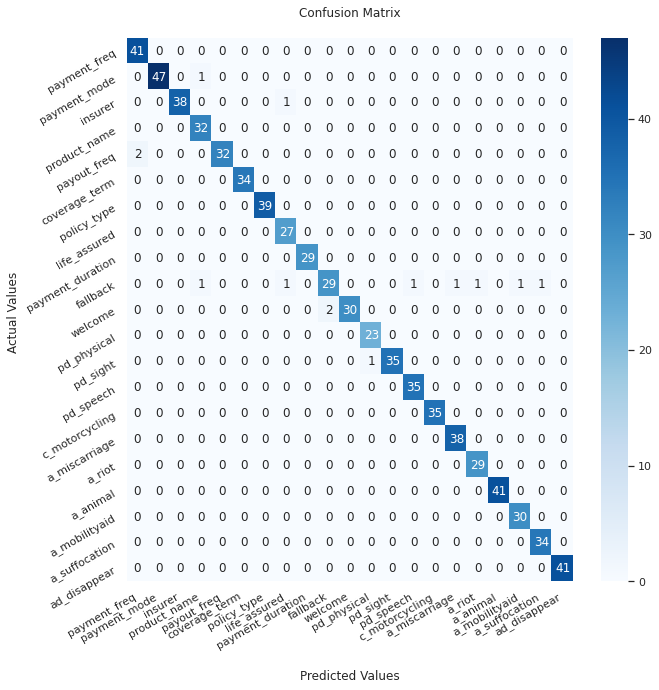

In [49]:
cf_matrix = confusion_matrix(test_label, y_pred, labels=unique_labels.tolist())
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues') 
ax.set_title('Confusion Matrix\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(unique_labels.tolist())
ax.yaxis.set_ticklabels(unique_labels.tolist())
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, horizontalalignment='right'); 
ax.set_yticklabels(ax.get_yticklabels(), rotation=30, horizontalalignment='right'); 

## Display the visualization of the Confusion Matrix.
plt.show()

In [86]:
sns.set(rc = {'figure.figsize':(5,3)}) 

## Example of predicting customer's question
the codes below is an example of how the customer would ask a question and the model would predict the question just like how it predicted the test data except that there would only be one question now.

In [51]:
# eg if customer ask in chatbot, start by tokenizing the question first
customer = np.array(['waht is the freqeuncy of my payout'])
qns = Dataset(preparing(customer,tokenizer))
ans = trainer.predict(qns).predictions.argmax(1)
result = labelencoder.inverse_transform(ans)
print("The label is:", result[0])

***** Running Prediction *****
  Num examples = 1
  Batch size = 64


The label is: payout_freq


## Other models

Using berttokenizer with pretrained model bert-based-cased to compare with pretrained model bert-based-uncased

In [52]:
#https://medium.com/@dhartidhami/understanding-bert-word-embeddings-7dc4d2ea54ca
pretrained1 = "bert-base-cased"
tokenizer1 = BertTokenizer.from_pretrained(pretrained1)

tokenizer1.tokenize("What is my payment Frequency?")

loading file https://huggingface.co/bert-base-cased/resolve/main/vocab.txt from cache at /home/p1936207/.cache/huggingface/transformers/6508e60ab3c1200bffa26c95f4b58ac6b6d95fba4db1f195f632fa3cd7bc64cc.437aa611e89f6fc6675a049d2b5545390adbc617e7d655286421c191d2be2791
loading file https://huggingface.co/bert-base-cased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/bert-base-cased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/bert-base-cased/resolve/main/tokenizer_config.json from cache at /home/p1936207/.cache/huggingface/transformers/ec84e86ee39bfe112543192cf981deebf7e6cbe8c91b8f7f8f63c9be44366158.ec5c189f89475aac7d8cbd243960a0655cfadc3d0474da8ff2ed0bf1699c2a5f
loading file https://huggingface.co/bert-base-cased/resolve/main/tokenizer.json from cache at /home/p1936207/.cache/huggingface/transformers/226a307193a9f4344264cdc76a12988448a25345ba172f2c7421f3b6810fddad.3dab63143af66769bbb35e3811f75f7e16b2320e

['What', 'is', 'my', 'payment', 'Fr', '##e', '##que', '##ncy', '?']

As this is using the cased pretrained model, it makes a difference between the upper and lower cased letters

In [53]:
#eg of how tokenize works
tokenized_input1 = tokenizer1.encode("What is my payment Frequency?")
# will print 101, tokenized words, 102
print( tokenized_input1 ) 

[101, 1327, 1110, 1139, 7727, 13359, 1162, 3530, 7232, 136, 102]


In [54]:
# tokenize the split data's question
train_t1 = tokenizer1(trainq_list, truncation=True, padding=True)
train_dataset1 = Dataset(train_t1, train_l.tolist())
test_dataset1 = Dataset(preparing(test_txt, tokenizer1), test_l.tolist())
model1 = BertForSequenceClassification.from_pretrained(pretrained1, num_labels=len(uniquel))
trainer1 = Trainer(
    model=model1, 
    args=training_args,
    train_dataset=train_dataset1, 
    eval_dataset=test_dataset1,
    compute_metrics=compute_metrics
)

# training of the data would take place here, the logging would show the progress of training in the form of a table per epoch
trainer1.train()

loading configuration file https://huggingface.co/bert-base-cased/resolve/main/config.json from cache at /home/p1936207/.cache/huggingface/transformers/a803e0468a8fe090683bdc453f4fac622804f49de86d7cecaee92365d4a0f829.a64a22196690e0e82ead56f388a3ef3a50de93335926ccfa20610217db589307
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16",
    "17": "LABEL_17",
    "18": "LABEL_18",
    "19": "LABEL_19",
    "20": "LABEL_20"
  },
  

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.594200,1.386413,0.840382,0.840382,0.840382,0.840382
2,0.521400,0.347042,0.963165,0.963165,0.963165,0.963165
3,0.172500,0.160828,0.975443,0.975443,0.975443,0.975443
4,0.076200,0.091258,0.983629,0.983629,0.983629,0.983629
5,0.100900,0.087546,0.983629,0.983629,0.983629,0.983629


***** Running Evaluation *****
  Num examples = 733
  Batch size = 64
***** Running Evaluation *****
  Num examples = 733
  Batch size = 64
***** Running Evaluation *****
  Num examples = 733
  Batch size = 64
***** Running Evaluation *****
  Num examples = 733
  Batch size = 64
***** Running Evaluation *****
  Num examples = 733
  Batch size = 64


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=230, training_loss=0.7275576852585959, metrics={'train_runtime': 44.7886, 'train_samples_per_second': 327.092, 'train_steps_per_second': 5.135, 'total_flos': 203303383215300.0, 'train_loss': 0.7275576852585959, 'epoch': 5.0})

In [55]:
bbc_10 = trainer1.evaluate() # this is the actual metrics after prediction
bbc_10

***** Running Evaluation *****
  Num examples = 733
  Batch size = 64


{'eval_loss': 0.08754593878984451,
 'eval_accuracy': 0.9836289222373806,
 'eval_f1': 0.9836289222373806,
 'eval_precision': 0.9836289222373806,
 'eval_recall': 0.9836289222373806,
 'eval_runtime': 1.2713,
 'eval_samples_per_second': 576.582,
 'eval_steps_per_second': 9.439,
 'epoch': 5.0}

In [56]:
loghist = trainer1.state.log_history
loss = []
eval_loss = []
eval_accuracy = []
epoch_4 = []
epoch_10 = []
eval_loss5bc = ''
eval_accuracy5bc = ''

for i in loghist[:-2]: #used get the different values in dictionary and append them accordingly
    if len(getkey(i)) == 4:
        if getkey(i)[0]=='loss':
            loss.append(i.get('loss'))
        if getkey(i)[2]=='epoch':
            epoch_4.append(i.get('epoch'))
    elif len(getkey(i)) == 10:
        if getkey(i)[0]=='eval_loss':
            eval_loss.append(i.get('eval_loss'))
        if getkey(i)[1]=='eval_accuracy':
            eval_accuracy.append(i.get('eval_accuracy'))
        if getkey(i)[-2]=='epoch':
            epoch_10.append(i.get('epoch'))
            if i.get('epoch') == 2:
                eval_loss5bc = i.get('eval_loss')
                eval_accuracy5bc = i.get('eval_accuracy')
    
history_4 = np.array([epoch_4, loss])
history_10 = np.array([epoch_10, eval_loss, eval_accuracy])

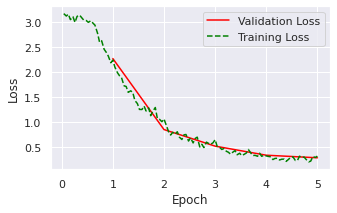

In [87]:
#see the training loss vs validation loss
plot_loss(history_10, history_4)

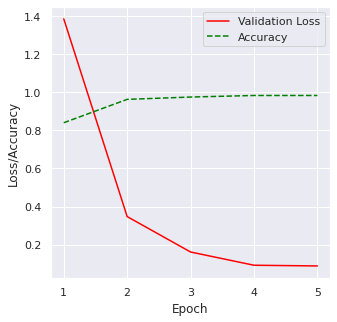

In [58]:
#see the loss and accuracy of the training
loss_accuracy(history_10)

Comparing AutoTokenizer and BertTokenizer

In [59]:
pretraineda = "bert-base-uncased"
tokenizera = AutoTokenizer.from_pretrained(pretraineda)

tokenizera.tokenize("What is my payment Frequency?")

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /home/p1936207/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.16.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file https://huggingface.co/bert-base-uncased/r

['what', 'is', 'my', 'payment', 'frequency', '?']

In [60]:
#eg of how tokenize works
tokenized_inputa = tokenizera.encode("What is my payment Frequency?")
# will print 101, tokenized words, 102
print( tokenized_inputa ) 

[101, 2054, 2003, 2026, 7909, 6075, 1029, 102]


In [61]:
# tokenize the split data's question
train_ta = tokenizera(trainq_list, truncation=True, padding=True)
train_dataseta = Dataset(train_ta, train_l.tolist())
test_dataseta = Dataset(preparing(test_txt, tokenizera), test_l.tolist())
modela = BertForSequenceClassification.from_pretrained(pretraineda, num_labels=len(uniquel))
trainera = Trainer(
    model=modela, 
    args=training_args,
    train_dataset=train_dataseta, 
    eval_dataset=test_dataseta,
    compute_metrics=compute_metrics
)

# training of the data would take place here, the logging would show the progress of training in the form of a table per epoch
trainera.train()

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /home/p1936207/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16",
    "17": "LABEL_17",
    "18": "LABEL_18",
    "19": "LABEL_19",
    "20": "LABEL_20"
  },


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.799000,1.619187,0.762619,0.762619,0.762619,0.762619
2,0.616700,0.520806,0.946794,0.946794,0.946794,0.946794
3,0.261700,0.228276,0.971351,0.971351,0.971351,0.971351
4,0.124500,0.149512,0.979536,0.979536,0.979536,0.979536
5,0.208800,0.135329,0.980900,0.980900,0.980900,0.980900


***** Running Evaluation *****
  Num examples = 733
  Batch size = 64
***** Running Evaluation *****
  Num examples = 733
  Batch size = 64
***** Running Evaluation *****
  Num examples = 733
  Batch size = 64
***** Running Evaluation *****
  Num examples = 733
  Batch size = 64
***** Running Evaluation *****
  Num examples = 733
  Batch size = 64


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=230, training_loss=0.8289985063931217, metrics={'train_runtime': 46.6946, 'train_samples_per_second': 313.741, 'train_steps_per_second': 4.926, 'total_flos': 195773628281400.0, 'train_loss': 0.8289985063931217, 'epoch': 5.0})

In [62]:
atoku_10 = trainera.evaluate() # this is the actual metrics after prediction
atoku_10

***** Running Evaluation *****
  Num examples = 733
  Batch size = 64


{'eval_loss': 0.13532908260822296,
 'eval_accuracy': 0.9809004092769441,
 'eval_f1': 0.9809004092769441,
 'eval_precision': 0.9809004092769441,
 'eval_recall': 0.9809004092769441,
 'eval_runtime': 1.3094,
 'eval_samples_per_second': 559.792,
 'eval_steps_per_second': 9.164,
 'epoch': 5.0}

In [63]:
loghist = trainera.state.log_history
loss = []
eval_loss = []
eval_accuracy = []
epoch_4 = []
epoch_10 = []
eval_loss5au = ''
eval_accuracy5au = ''

for i in loghist[:-2]: #used get the different values in dictionary and append them accordingly
    if len(getkey(i)) == 4:
        if getkey(i)[0]=='loss':
            loss.append(i.get('loss'))
        if getkey(i)[2]=='epoch':
            epoch_4.append(i.get('epoch'))
    elif len(getkey(i)) == 10:
        if getkey(i)[0]=='eval_loss':
            eval_loss.append(i.get('eval_loss'))
        if getkey(i)[1]=='eval_accuracy':
            eval_accuracy.append(i.get('eval_accuracy'))
        if getkey(i)[-2]=='epoch':
            epoch_10.append(i.get('epoch'))
            if i.get('epoch') == 2:
                eval_loss5au = i.get('eval_loss')
                eval_accuracy5au = i.get('eval_accuracy')
    
history_4 = np.array([epoch_4, loss])
history_10 = np.array([epoch_10, eval_loss, eval_accuracy])

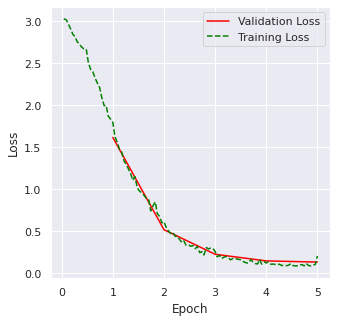

In [64]:
#see the training loss vs validation loss
plot_loss(history_10, history_4)

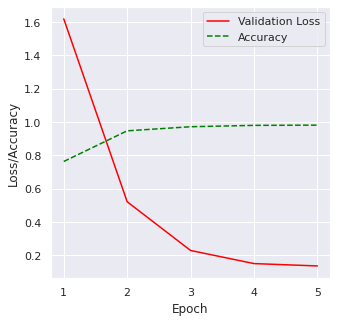

In [65]:
#see the loss and accuracy of the training
loss_accuracy(history_10)

Comparing AutoTokenizer's bert-base-cased and bert-based-uncased

In [66]:
pretraineda1 = "bert-base-cased"
tokenizera1 = AutoTokenizer.from_pretrained(pretraineda1)

#eg of how tokenize works
tokenized_inputa1 = tokenizera1.encode("What is my payment Frequency?")
# will print 101, tokenized words, 102
print( tokenized_inputa1 ) 

loading configuration file https://huggingface.co/bert-base-cased/resolve/main/config.json from cache at /home/p1936207/.cache/huggingface/transformers/a803e0468a8fe090683bdc453f4fac622804f49de86d7cecaee92365d4a0f829.a64a22196690e0e82ead56f388a3ef3a50de93335926ccfa20610217db589307
Model config BertConfig {
  "_name_or_path": "bert-base-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.16.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

loading file https://huggingface.co/bert-base-cased/resolve

[101, 1327, 1110, 1139, 7727, 13359, 1162, 3530, 7232, 136, 102]


In [67]:
# tokenize the split data's question
train_ta1 = tokenizera1(trainq_list, truncation=True, padding=True)
train_dataseta1 = Dataset(train_ta1, train_l.tolist())
test_dataseta1 = Dataset(preparing(test_txt, tokenizera1), test_l.tolist())
modela1 = BertForSequenceClassification.from_pretrained(pretraineda1, num_labels=len(uniquel))
trainera1 = Trainer(
    model=modela1, 
    args=training_args,
    train_dataset=train_dataseta1, 
    eval_dataset=test_dataseta1,
    compute_metrics=compute_metrics
)

# training of the data would take place here, the logging would show the progress of training in the form of a table per epoch
trainera1.train()

loading configuration file https://huggingface.co/bert-base-cased/resolve/main/config.json from cache at /home/p1936207/.cache/huggingface/transformers/a803e0468a8fe090683bdc453f4fac622804f49de86d7cecaee92365d4a0f829.a64a22196690e0e82ead56f388a3ef3a50de93335926ccfa20610217db589307
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16",
    "17": "LABEL_17",
    "18": "LABEL_18",
    "19": "LABEL_19",
    "20": "LABEL_20"
  },
  

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.319500,1.166229,0.877217,0.877217,0.877217,0.877217
2,0.349000,0.292960,0.968622,0.968622,0.968622,0.968622
3,0.160300,0.129435,0.984993,0.984993,0.984993,0.984993
4,0.060500,0.082362,0.987722,0.987722,0.987722,0.987722
5,0.097200,0.076795,0.987722,0.987722,0.987722,0.987722


***** Running Evaluation *****
  Num examples = 733
  Batch size = 64
***** Running Evaluation *****
  Num examples = 733
  Batch size = 64
***** Running Evaluation *****
  Num examples = 733
  Batch size = 64
***** Running Evaluation *****
  Num examples = 733
  Batch size = 64
***** Running Evaluation *****
  Num examples = 733
  Batch size = 64


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=230, training_loss=0.657224846922833, metrics={'train_runtime': 45.9431, 'train_samples_per_second': 318.873, 'train_steps_per_second': 5.006, 'total_flos': 203303383215300.0, 'train_loss': 0.657224846922833, 'epoch': 5.0})

In [68]:
atokc_10 = trainera1.evaluate() # this is the actual metrics after prediction
atokc_10

***** Running Evaluation *****
  Num examples = 733
  Batch size = 64


{'eval_loss': 0.07679492980241776,
 'eval_accuracy': 0.9877216916780355,
 'eval_f1': 0.9877216916780355,
 'eval_precision': 0.9877216916780355,
 'eval_recall': 0.9877216916780355,
 'eval_runtime': 1.2952,
 'eval_samples_per_second': 565.925,
 'eval_steps_per_second': 9.265,
 'epoch': 5.0}

In [69]:
loghist = trainera1.state.log_history
loss = []
eval_loss = []
eval_accuracy = []
epoch_4 = []
epoch_10 = []
eval_loss5ac = ''
eval_accuracy5ac = ''

for i in loghist[:-2]: #used get the different values in dictionary and append them accordingly
    if len(getkey(i)) == 4:
        if getkey(i)[0]=='loss':
            loss.append(i.get('loss'))
        if getkey(i)[2]=='epoch':
            epoch_4.append(i.get('epoch'))
    elif len(getkey(i)) == 10:
        if getkey(i)[0]=='eval_loss':
            eval_loss.append(i.get('eval_loss'))
        if getkey(i)[1]=='eval_accuracy':
            eval_accuracy.append(i.get('eval_accuracy'))
        if getkey(i)[-2]=='epoch':
            epoch_10.append(i.get('epoch'))
            if i.get('epoch') == 2:
                eval_loss5ac = i.get('eval_loss')
                eval_accuracy5ac = i.get('eval_accuracy')
    
history_4 = np.array([epoch_4, loss])
history_10 = np.array([epoch_10, eval_loss, eval_accuracy])

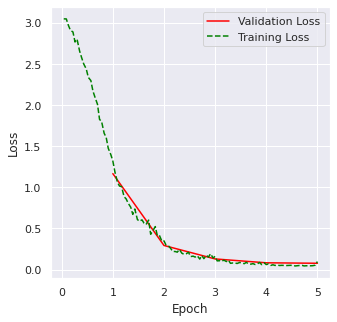

In [70]:
#see the training loss vs validation loss
plot_loss(history_10, history_4)

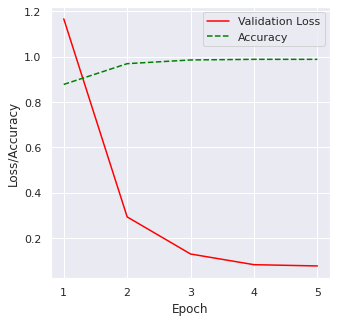

In [71]:
#see the loss and accuracy of the training
loss_accuracy(history_10)

Comparing DistilBertTokenizerFast

In [72]:
pretrainedd = "distilbert-base-uncased"
tokenizerd = DistilBertTokenizerFast.from_pretrained(pretrainedd)

tokenized_inputd = tokenizerd.tokenize("What is my payment Frequency?")
# will print 101, tokenized words, 102
print( tokenized_inputd ) 

loading file https://huggingface.co/distilbert-base-uncased/resolve/main/vocab.txt from cache at /home/p1936207/.cache/huggingface/transformers/0e1bbfda7f63a99bb52e3915dcf10c3c92122b827d92eb2d34ce94ee79ba486c.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/distilbert-base-uncased/resolve/main/tokenizer.json from cache at /home/p1936207/.cache/huggingface/transformers/75abb59d7a06f4f640158a9bfcde005264e59e8d566781ab1415b139d2e4c603.7f2721073f19841be16f41b0a70b600ca6b880c8f3df6f3535cbc704371bdfa4
loading file https://huggingface.co/distilbert-base-uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/distilbert-base-uncased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/distilbert-base-uncased/resolve/main/tokenizer_config.json from cache at /home/p1936207/.cache/huggingface/transformers/8c8624b8ac8aa99c60c912161f8332de003484428c47906d7ff7eb7f73eecdbb.

['what', 'is', 'my', 'payment', 'frequency', '?']


In [73]:
# tokenize the split data's question
train_td = tokenizerd(trainq_list, truncation=True, padding=True)
train_datasetd = Dataset(train_td, train_l.tolist())
test_datasetd = Dataset(preparing(test_txt, tokenizerd), test_l.tolist())
modeld = BertForSequenceClassification.from_pretrained(pretrainedd, num_labels=len(uniquel))
trainerd = Trainer(
    model=modeld, 
    args=training_args,
    train_dataset=train_datasetd, 
    eval_dataset=test_datasetd,
    compute_metrics=compute_metrics
)

# training of the data would take place here, the logging would show the progress of training in the form of a table per epoch
trainerd.train()

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /home/p1936207/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Model config BertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "dim": 768,
  "dropout": 0.1,
  "hidden_act": "gelu",
  "hidden_dim": 3072,
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10"

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['encoder.layer.3.attention.output.LayerNorm.bias', 'encoder.layer.11.attention.self.query.bias', 'encoder.layer.5.attention.self.key.weight', 'encoder.layer.2.attention.self.key.weight', 'encoder.layer.9.attention.self.query.weight', 'encoder.layer.6.attention.self.value.bias', 'encoder.layer.11.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.3.attention.self.key.bias', 'encoder.layer.5.attention.output.dense.weight', 'encoder.layer.8.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.6.output.LayerNorm.weight', 'encoder.layer.5.output.LayerNorm.bias', 'encoder.layer.4.attention.self.query.bias', 'encoder.layer.1.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.1.attention.output.dense.weight', 'encoder.layer.7

/opt/conda/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2930
  Num Epochs = 5
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 230
/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,2.244200,2.274887,0.361528,0.361528,0.361528,0.361528
2,1.064400,0.852159,0.843111,0.843111,0.843111,0.843111
3,0.649800,0.519973,0.888131,0.888131,0.888131,0.888131
4,0.323800,0.337852,0.934516,0.934516,0.934516,0.934516
5,0.318600,0.286243,0.935880,0.935880,0.935880,0.935880


***** Running Evaluation *****
  Num examples = 733
  Batch size = 64
***** Running Evaluation *****
  Num examples = 733
  Batch size = 64
***** Running Evaluation *****
  Num examples = 733
  Batch size = 64
***** Running Evaluation *****
  Num examples = 733
  Batch size = 64
***** Running Evaluation *****
  Num examples = 733
  Batch size = 64


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=230, training_loss=1.1262313657480738, metrics={'train_runtime': 45.6244, 'train_samples_per_second': 321.1, 'train_steps_per_second': 5.041, 'total_flos': 195773628281400.0, 'train_loss': 1.1262313657480738, 'epoch': 5.0})

In [74]:
du_10 = trainerd.evaluate() # this is the actual metrics after prediction
du_10

***** Running Evaluation *****
  Num examples = 733
  Batch size = 64


{'eval_loss': 0.28624337911605835,
 'eval_accuracy': 0.9358799454297408,
 'eval_f1': 0.9358799454297408,
 'eval_precision': 0.9358799454297408,
 'eval_recall': 0.9358799454297408,
 'eval_runtime': 1.2769,
 'eval_samples_per_second': 574.028,
 'eval_steps_per_second': 9.397,
 'epoch': 5.0}

In [75]:
loghist = trainerd.state.log_history
loss = []
eval_loss = []
eval_accuracy = []
epoch_4 = []
epoch_10 = []
eval_loss5du = ''
eval_accuracy5du = ''

for i in loghist[:-2]: #used get the different values in dictionary and append them accordingly
    if len(getkey(i)) == 4:
        if getkey(i)[0]=='loss':
            loss.append(i.get('loss'))
        if getkey(i)[2]=='epoch':
            epoch_4.append(i.get('epoch'))
    elif len(getkey(i)) == 10:
        if getkey(i)[0]=='eval_loss':
            eval_loss.append(i.get('eval_loss'))
        if getkey(i)[1]=='eval_accuracy':
            eval_accuracy.append(i.get('eval_accuracy'))
        if getkey(i)[-2]=='epoch':
            epoch_10.append(i.get('epoch'))
            if i.get('epoch') == 2:
                eval_loss5du = i.get('eval_loss')
                eval_accuracy5du = i.get('eval_accuracy')
    
history_4 = np.array([epoch_4, loss])
history_10 = np.array([epoch_10, eval_loss, eval_accuracy])

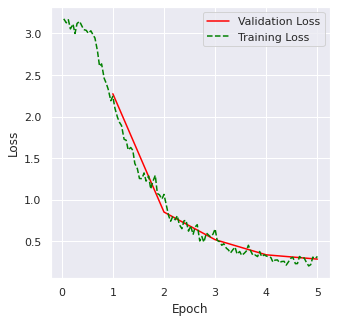

In [76]:
#see the training loss vs validation loss
plot_loss(history_10, history_4)

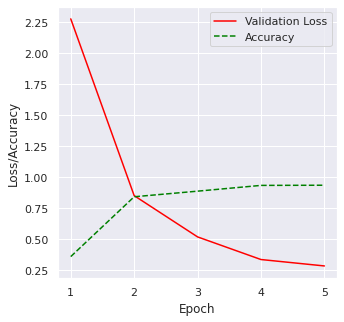

In [77]:
#see the loss and accuracy of the training
loss_accuracy(history_10)

## Compare models

In [78]:
tokenizer = ['BertTokenizer','BertTokenizer','BertTokenizer','BertTokenizer', 'AutoTokenizer', 'AutoTokenizer', 'AutoTokenizer', 'AutoTokenizer', 'DistilBertTokenizerFast', 'DistilBertTokenizerFast']
pretrained_model = [pretrained, pretrained, pretrained1, pretrained1, pretraineda, pretraineda, pretraineda1, pretraineda1, pretrainedd, pretrainedd]
epoch = [2, bbu_10['epoch'], 2, bbc_10['epoch'], 2, atoku_10['epoch'], 2, atokc_10['epoch'], 2, du_10['epoch']]
eval_accuracy = [eval_accuracy5, bbu_10['eval_accuracy'], eval_accuracy5bc, bbc_10['eval_accuracy'], eval_accuracy5au, atoku_10['eval_accuracy'], eval_accuracy5ac, atokc_10['eval_accuracy'], eval_accuracy5du, du_10['eval_accuracy']]
eval_loss = [eval_loss5, bbu_10['eval_loss'], eval_loss5bc, bbc_10['eval_loss'], eval_loss5au, atoku_10['eval_loss'], eval_loss5ac, atokc_10['eval_loss'], eval_loss5du, du_10['eval_loss']]

compare = pd.DataFrame({'tokenizer': tokenizer,
                        'pretrained model': pretrained_model,
                        'epochs': epoch,
                        'eval_accuracy': eval_accuracy,
                        'eval_loss': eval_loss})
compare

,tokenizer,pretrained model,epochs,eval_accuracy,eval_loss
0,BertTokenizer,bert-base-uncased,2.0,0.945430,0.460349
1,BertTokenizer,bert-base-uncased,5.0,0.980900,0.117782
2,BertTokenizer,bert-base-cased,2.0,0.963165,0.347042
3,BertTokenizer,bert-base-cased,5.0,0.983629,0.087546
4,AutoTokenizer,bert-base-uncased,2.0,0.946794,0.520806
5,AutoTokenizer,bert-base-uncased,5.0,0.980900,0.135329
6,AutoTokenizer,bert-base-cased,2.0,0.968622,0.292960
7,AutoTokenizer,bert-base-cased,5.0,0.987722,0.076795
8,DistilBertTokenizerFast,distilbert-base-uncased,2.0,0.843111,0.852159
9,DistilBertTokenizerFast,distilbert-base-uncased,5.0,0.935880,0.286243


The smaller the loss, the better a job the classifier is at modeling the relationship between the input data and the output targets. The higher the accuracy, the better the model is. However, sometimes, higher accuracy might mean overfitting.

AutoTokenizer's accuracy and loss is better than BertTokenizer's so AutoTokenizer will be used.

## Save Model

In [79]:
torch.save(modela, 'model.pt')

In [80]:
ai_model = torch.load('model.pt')

In [81]:

print('Has access to GPU: ', torch.cuda.is_available())

trainer = Trainer(
            model=ai_model
        )

customer = np.array(['insurier'])
qns = Dataset(preparing(customer,tokenizera))
ans = trainer.predict(qns).predictions.argmax(1)
result = labelencoder.inverse_transform(ans)
print("The label is:", result[0])

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 1
  Batch size = 64


Has access to GPU:  True


The label is: insurer


## Resources

https://medium.com/@nutanbhogendrasharma/step-by-step-intent-recognition-with-bert-1473202b8597

https://towardsdatascience.com/fine-tuning-pretrained-nlp-models-with-huggingfaces-trainer-6326a4456e7b

https://medium.com/analytics-vidhya/creating-your-own-intent-classifier-b86e000a4926

https://colab.research.google.com/github/huggingface/notebooks/blob/master/transformers_doc/training.ipynb#scrollTo=XSQddZTy1KFO

https://www.tensorflow.org/api_docs/python/tf/nn/softmax

https://ai.stackexchange.com/questions/26629/how-do-i-calculate-the-probabilities-of-the-bert-model-prediction-logits

https://stackoverflow.com/questions/34240703/what-are-logits-what-is-the-difference-between-softmax-and-softmax-cross-entrop

https://www.kaggle.com/mohamedbakrey/eda-for-intent-classification-for-english/notebook


#### Huggingface
https://huggingface.co/docs/datasets/quicktour.html

https://huggingface.co/transformers/main_classes/trainer.html#transformers.TrainingArguments

https://huggingface.co/transformers/preprocessing.html

https://huggingface.co/transformers/v3.0.2/training.html

https://huggingface.co/docs/datasets/torch_tensorflow.html

https://huggingface.co/transformers/training.html

https://huggingface.co/transformers/main_classes/tokenizer.html

https://huggingface.co/transformers/main_classes/trainer.html

##### pipelines 
https://huggingface.co/docs/transformers/main_classes/pipelines

https://huggingface.co/docs/transformers/v4.15.0/add_new_pipeline

#### Freeze layer
https://discuss.huggingface.co/t/how-to-freeze-layers-using-trainer/4702

https://www.researchgate.net/post/How-to-choose-from-which-layer-to-start-unfreezing-pretrained-model

#### Tokenizer
https://github.com/huggingface/transformers/issues/5587

https://huggingface.co/docs/transformers/tokenizer_summary

https://www.google.com/search?q=difference+between+bert-based+case+and+uncase&oq=difference+between+bert-based+case+and+uncase&aqs=chrome..69i57.10136j0j1&sourceid=chrome&ie=UTF-8